In [29]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [30]:
import numpy as np
import pandas as pd

In [31]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [32]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [33]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [34]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [35]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [36]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [37]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Design a query to retrieve the last 12 months of precipitation data and plot the results

In [38]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(last_date)

('2017-08-23',)


In [39]:
# Calculate the date 1 year ago from the last data point in the database
# year_ago_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago_date = dt.date(2017, 8, 23) - dt.timedelta(days=366)
year_ago_date

datetime.date(2016, 8, 22)

In [40]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago_date)\
                    .filter(Measurement.date <= last_date[0]).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(query, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
prcp_df.set_index('Date', inplace=True)
prcp_df = prcp_df.sort_values(by='Date', ascending=True)
prcp_df.head(15)

,Precipitation
Date,
2016-08-22,0.40
2016-08-22,0.94
2016-08-22,NaN
2016-08-22,NaN
2016-08-22,0.40
2016-08-22,2.32
2016-08-22,1.20
2016-08-23,0.70
2016-08-23,1.79


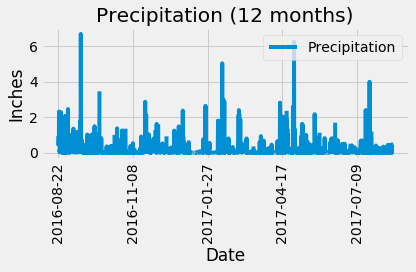

In [41]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation (12 months)")

plt.legend(loc='upper right')
plt.ylabel("Inches")
plt.xticks(rotation=90)

plt.tight_layout()

plt.savefig("Result_Images/Precipitation.png")
plt.show()

In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2026.000000
mean,0.179437
std,0.463989
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [43]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
print(f"Total Number of Available Stations: {available_stations} ")

Total Number of Available Stations: 9 


In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by\
                                (func.count(Measurement.station).desc()).all()
# active_stations
active_station_df = pd.DataFrame(active_stations, columns=['Station Name', 'Total Rows'])
active_station_df

,Station Name,Total Rows
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [45]:
# Station with the highest number of observations
most_active_station = active_stations[0][0]

print(f"With the highest number of observations of {active_stations[0][1]}, \
The Most Active Station is {most_active_station}. ")

With the highest number of observations of 2772, The Most Active Station is USC00519281. 


In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded, \
# highest temperature recorded, and average temperature of the most active station?

temps_most_active_station = session.query(func.min(Measurement.tobs), 
                                          func.max(Measurement.tobs), 
                                          func.avg(Measurement.tobs)).filter(Measurement.station == \
                                                                             most_active_station).all()
                                                                     
# temps_most_active_station

print(f"Temparature Records for '{most_active_station}' station -- ")
print(f"Lowest: {temps_most_active_station[0][0]}")
print(f"Highest: {temps_most_active_station[0][1]}")
print(f"Average: {round(temps_most_active_station[0][2], 1)}")

Temparature Records for 'USC00519281' station -- 
Lowest: 54.0
Highest: 85.0
Average: 71.7


In [47]:
# Choose the station with the highest number of temperature observations.

highest_temp_obs_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station)\
                                    .order_by(func.count(Measurement.station).desc()).first()
highest_temp_obs_station = highest_temp_obs_station[0]


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.tobs).filter(Measurement.date >= year_ago_date)\
                    .filter(Measurement.station == highest_temp_obs_station).all()
temp_obs = pd.DataFrame(temp_obs, columns=['Temperature'])

temp_obs.head(15)

,Temperature
0,78.0
1,77.0
2,77.0
3,80.0
4,80.0
5,75.0
6,73.0
7,78.0
8,77.0
9,78.0


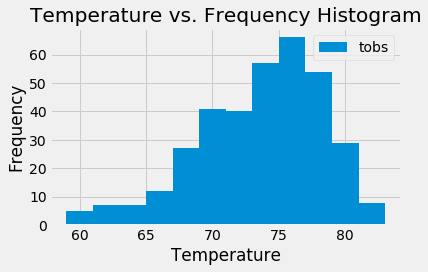

In [48]:
temp_obs.plot.hist(bins = 12, 
                   title = "Temperature vs. Frequency Histogram")

plt.xlabel("Temperature")
plt.legend(['tobs'], loc='upper right')
plt.tight_layout()

plt.savefig("Result_Images/TemperaturevsFrequency.png")
plt.show()